<a href="https://colab.research.google.com/github/Ishanavi/ConcurrencyControl/blob/main/Concurrency_Control_ish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install memory_profiler
from memory_profiler import profile
import os
import psutil
import time
import threading
import concurrent.futures
import queue
from queue import Queue
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

result = []

In [28]:
#mutexes

list_m = []

mutex = threading.Lock()

def mutex_in():
  global list_m
  for i in range(100000):
    with mutex:
      list_m.append([0]*1000)

def mutex_test():
    global list_m
    list_m = []

    #resource monitoring
    process = psutil.Process(os.getpid())

    #warm up
    threads = [threading.Thread(target=mutex_in) for j in range(3)]
    for i in threads:
        i.start()
    for i in threads:
        i.join()
    gc.collect()

    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    start_memory = process.memory_info().rss

    # Running threads
    threads = [threading.Thread(target=mutex_in) for j in range(10)]
    for i in threads:
        i.start()
    for i in threads:
        i.join()

    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    end_memory = process.memory_info().rss

    time_taken = end_time - start_time
    cpu = end_cpu - start_cpu
    memory = max(0,end_memory - start_memory)

    return time_taken, cpu, memory



tm1, cm1, mm1 = mutex_test()
tm2, cm2, mm2 = mutex_test()
tm3, cm3, mm3 = mutex_test()

time_taken_m = (tm1+tm2+tm3)/3
cpu_m = (cm1+cm2+cm3)/3
memory_m = (mm1+mm2+mm3)/3

print("Mutex -> Execution time (secondS):", time_taken_m)
print("Mutex -> CPU usage (%):", cpu_m)
print("Mutex -> Memory usage (bytes):", memory_m)

result.append({
        "Mechanism":"Mutex",
        "Execution Time": time_taken_m,
        "CPU Usage": cpu_m,
        "Memory Usage": memory_m
})

Mutex -> Execution time (secondS): 29.712964137395222
Mutex -> CPU usage (%): 121.93333333333334
Mutex -> Memory usage (bytes): 2091050325.3333333


In [29]:
#semaphore
list_s = []

semaphore = threading.Semaphore(1)

def semaphore_in():
  global list_s
  for i in range(100000):
    with semaphore:
      list_s.append([0]*1000)

def semaphore_test():
    global list_s
    list_s = []

    #resource monitoring
    process = psutil.Process(os.getpid())


    threads = [threading.Thread(target=semaphore_in) for j in range(3)]
    for i in threads:
        i.start()
    for i in threads:
        i.join()
    gc.collect()


    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    start_memory = process.memory_info().rss

    # Running threads
    threads = [threading.Thread(target=semaphore_in) for j in range(10)]
    for i in threads:
        i.start()
    for i in threads:
        i.join()

    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    end_memory = process.memory_info().rss

    time_taken = end_time - start_time
    cpu = end_cpu - start_cpu
    memory = max(0,end_memory - start_memory)

    return time_taken, cpu, memory


ts1, cs1, ms1 = semaphore_test()
ts2, cs2, ms2 = semaphore_test()
ts3, cs3, ms3 = semaphore_test()

time_taken_s = (ts1+ts2+ts3)/3
cpu_s = (cs1+cs2+cs3)/3
memory_s = (ms1+ms2+ms3)/3

print("Semaphore -> Execution time (seconds):", time_taken_s)
print("Semaphore -> CPU usage (%):", cpu_s)
print("Semaphore -> Memory usage (bytes):", memory_s)

result.append({
      "Mechanism": "Semaphore",
      "Execution Time": time_taken_s,
      "CPU Usage": cpu_s,
      "Memory Usage": memory_s
  })

Semaphore -> Execution time (seconds): 19.01984182993571
Semaphore -> CPU usage (%): 105.09999999999998
Semaphore -> Memory usage (bytes): 2329625941.3333335


In [30]:
#simulating lock free behaviour using concurrent.futures and queues
queue  = Queue()

def queue_in():
  global queue
  for i in range(100000):
    queue.put(0)

def queue_test(function):
    process = psutil.Process(os.getpid())

    threads = [threading.Thread(target=function) for _ in range(3)]
    for i in threads:
        i.start()
    for i in threads:
        i.join()
    gc.collect()


    start_time = time.time()
    start_cpu = process.cpu_percent(interval=None)
    start_memory = process.memory_info().rss

    threads = [threading.Thread(target=function) for _ in range(10)]
    for i in threads:
        i.start()
    for i in threads:
        i.join()

    end_time = time.time()
    end_cpu = process.cpu_percent(interval=None)
    end_memory = process.memory_info().rss

    time_taken = end_time - start_time
    cpu = end_cpu - start_cpu
    memory = max(0,end_memory - start_memory)

    return time_taken,cpu,memory

new_queue = Queue()

queue_time1, queue_cpu1, queue_memory1 = queue_test(queue_in)
queue_time2, queue_cpu2, queue_memory2 = queue_test(queue_in)
queue_time3, queue_cpu3, queue_memory3 = queue_test(queue_in)

queue_time = (queue_time1+queue_time2+queue_time3)/3
queue_cpu = (queue_cpu1+queue_cpu2+queue_cpu3)/3
queue_memory = (queue_memory1+queue_memory2+queue_memory3)/3


print("Queue -> Execution time (seconds):", queue_time)
print("Queue -> CPU usage (%):", queue_cpu)
print("Queue -> Memory usage (bytes):", queue_memory)

result.append({
    "Mechanism": "Queue",
    "Execution Time": queue_time,
    "CPU Usage": queue_cpu,
    "Memory Usage": queue_memory
})



Queue -> Execution time (seconds): 13.61470651626587
Queue -> CPU usage (%): 144.73333333333335
Queue -> Memory usage (bytes): 2580480.0


In [31]:
df_result = pd.DataFrame(result)
print(df_result)
sns.set(style="whitegrid")

   Mechanism  Execution Time   CPU Usage  Memory Usage
0      Mutex       29.712964  121.933333  2.091050e+09
1  Semaphore       19.019842  105.100000  2.329626e+09
2      Queue       13.614707  144.733333  2.580480e+06


<ipython-input-32-5695f29e1391>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mechanism", y="Execution Time", data=df_result,palette='crest')


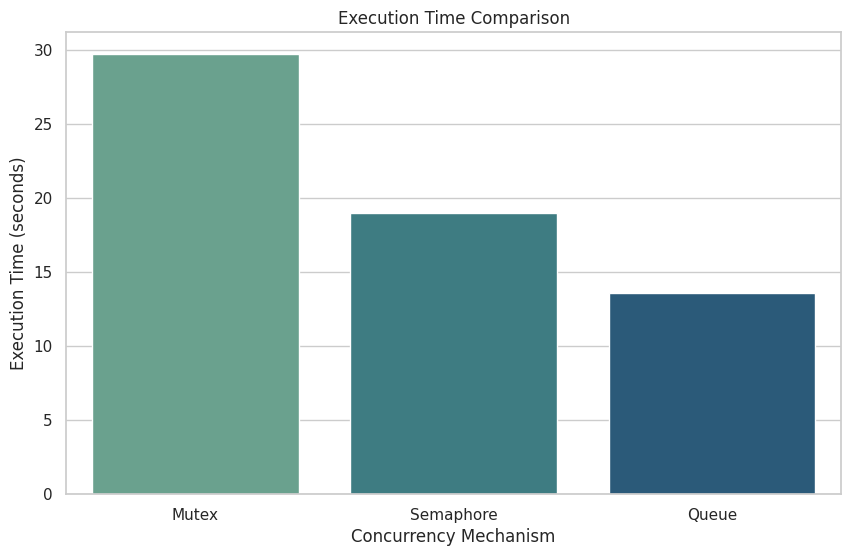

In [32]:
# Plotting Execution Time
plt.figure(figsize=(10, 6))
sns.barplot(x="Mechanism", y="Execution Time", data=df_result,palette='crest')
plt.title("Execution Time Comparison")
plt.xlabel("Concurrency Mechanism")
plt.ylabel("Execution Time (seconds)")
plt.show()

<ipython-input-33-6e8e52c9cb2a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mechanism", y="CPU Usage", data=df_result,palette='flare')


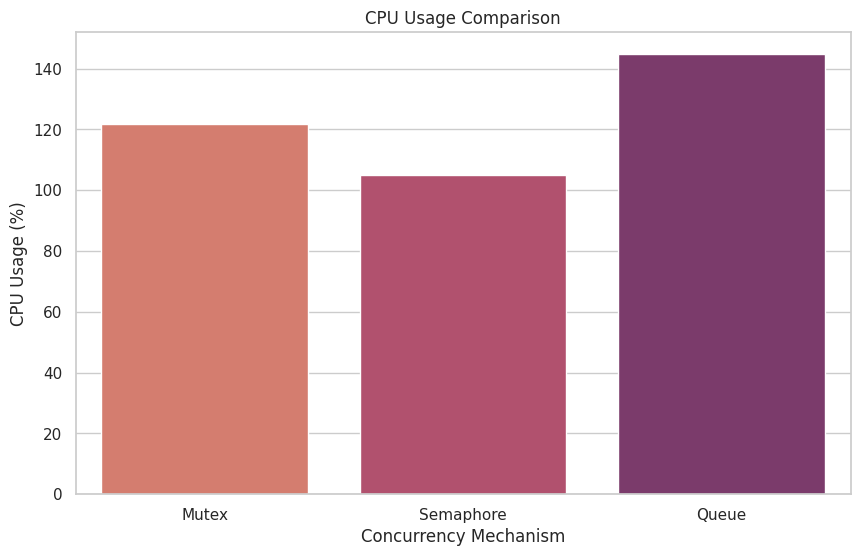

In [33]:
# Plotting CPU Usage
plt.figure(figsize=(10, 6))
sns.barplot(x="Mechanism", y="CPU Usage", data=df_result,palette='flare')
plt.title("CPU Usage Comparison")
plt.xlabel("Concurrency Mechanism")
plt.ylabel("CPU Usage (%)")
plt.show()

<ipython-input-34-4f1569300260>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Mechanism", y="Memory Usage", data=df_result, palette='YlOrBr')


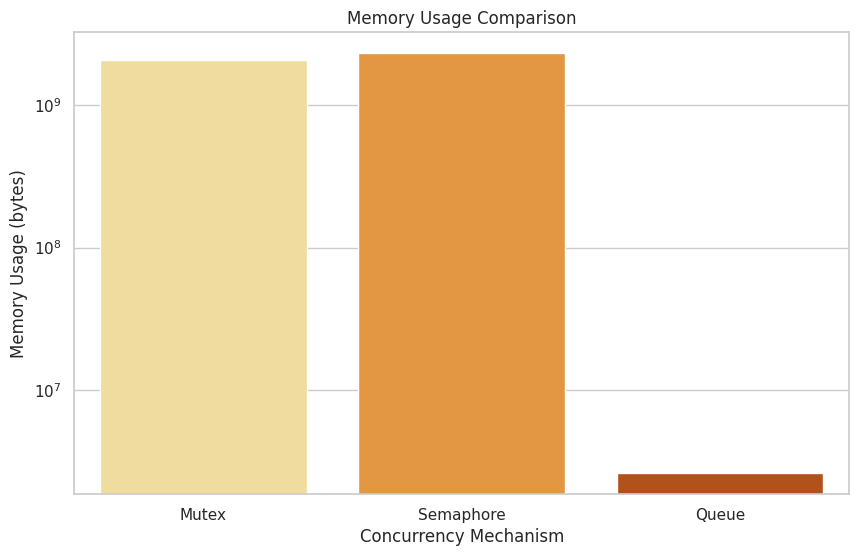

In [34]:
# Plotting Memory Usage
plt.figure(figsize=(10, 6))
sns.barplot(x="Mechanism", y="Memory Usage", data=df_result, palette='YlOrBr')
plt.title("Memory Usage Comparison")
plt.xlabel("Concurrency Mechanism")
plt.ylabel("Memory Usage (bytes)")
plt.yscale('log')
plt.show()